# 🚀 Desafio de Previsão de Sucesso de Startups

## Objetivo
Desenvolver um modelo de machine learning capaz de identificar quais startups apresentam maior probabilidade de se tornarem casos de sucesso no mercado.

### 📊 Dados Disponíveis
- **train.csv**: Conjunto de treinamento com startups + variável alvo (labels)
- **test.csv**: Conjunto de teste (sem a coluna alvo)
- **sample_submission.csv**: Modelo de submissão esperado

### 🎯 Meta
Criar um modelo que preveja, com boa acurácia, se uma startup será bem-sucedida (1) ou não (0).

---

In [2]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 📂 1. Carregamento e Exploração Inicial dos Dados

Vamos começar carregando os datasets e examinando sua estrutura básica.

In [3]:
# Carregar os datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

print("📊 Informações dos Datasets:")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

# Visualizar primeiras linhas do dataset de treino
print("\n📋 Primeiras 5 linhas do dataset de treino:")
train_df.head()

📊 Informações dos Datasets:
Training set shape: (646, 33)
Test set shape: (277, 32)
Sample submission shape: (277, 2)

📋 Primeiras 5 linhas do dataset de treino:


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


In [4]:
# Informações detalhadas sobre o dataset
print("🔍 Informações detalhadas do dataset de treino:")
print(train_df.info())

print("\n🎯 Distribuição da variável alvo:")
target_counts = train_df['labels'].value_counts()
print(target_counts)
print(f"Taxa de sucesso: {target_counts[1] / len(train_df) * 100:.2f}%")

# Verificar valores ausentes
print(f"\n❓ Valores ausentes no conjunto de treino:")
missing_train = train_df.isnull().sum()
missing_train = missing_train[missing_train > 0]
if len(missing_train) > 0:
    print(missing_train)
else:
    print("Nenhum valor ausente encontrado!")

print(f"\n❓ Valores ausentes no conjunto de teste:")
missing_test = test_df.isnull().sum()
missing_test = missing_test[missing_test > 0]
if len(missing_test) > 0:
    print(missing_test)
else:
    print("Nenhum valor ausente encontrado!")

🔍 Informações detalhadas do dataset de treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate     

## 📊 2. Análise Exploratória de Dados (EDA)

Vamos explorar os dados para entender os padrões e relações entre as variáveis e o sucesso das startups.

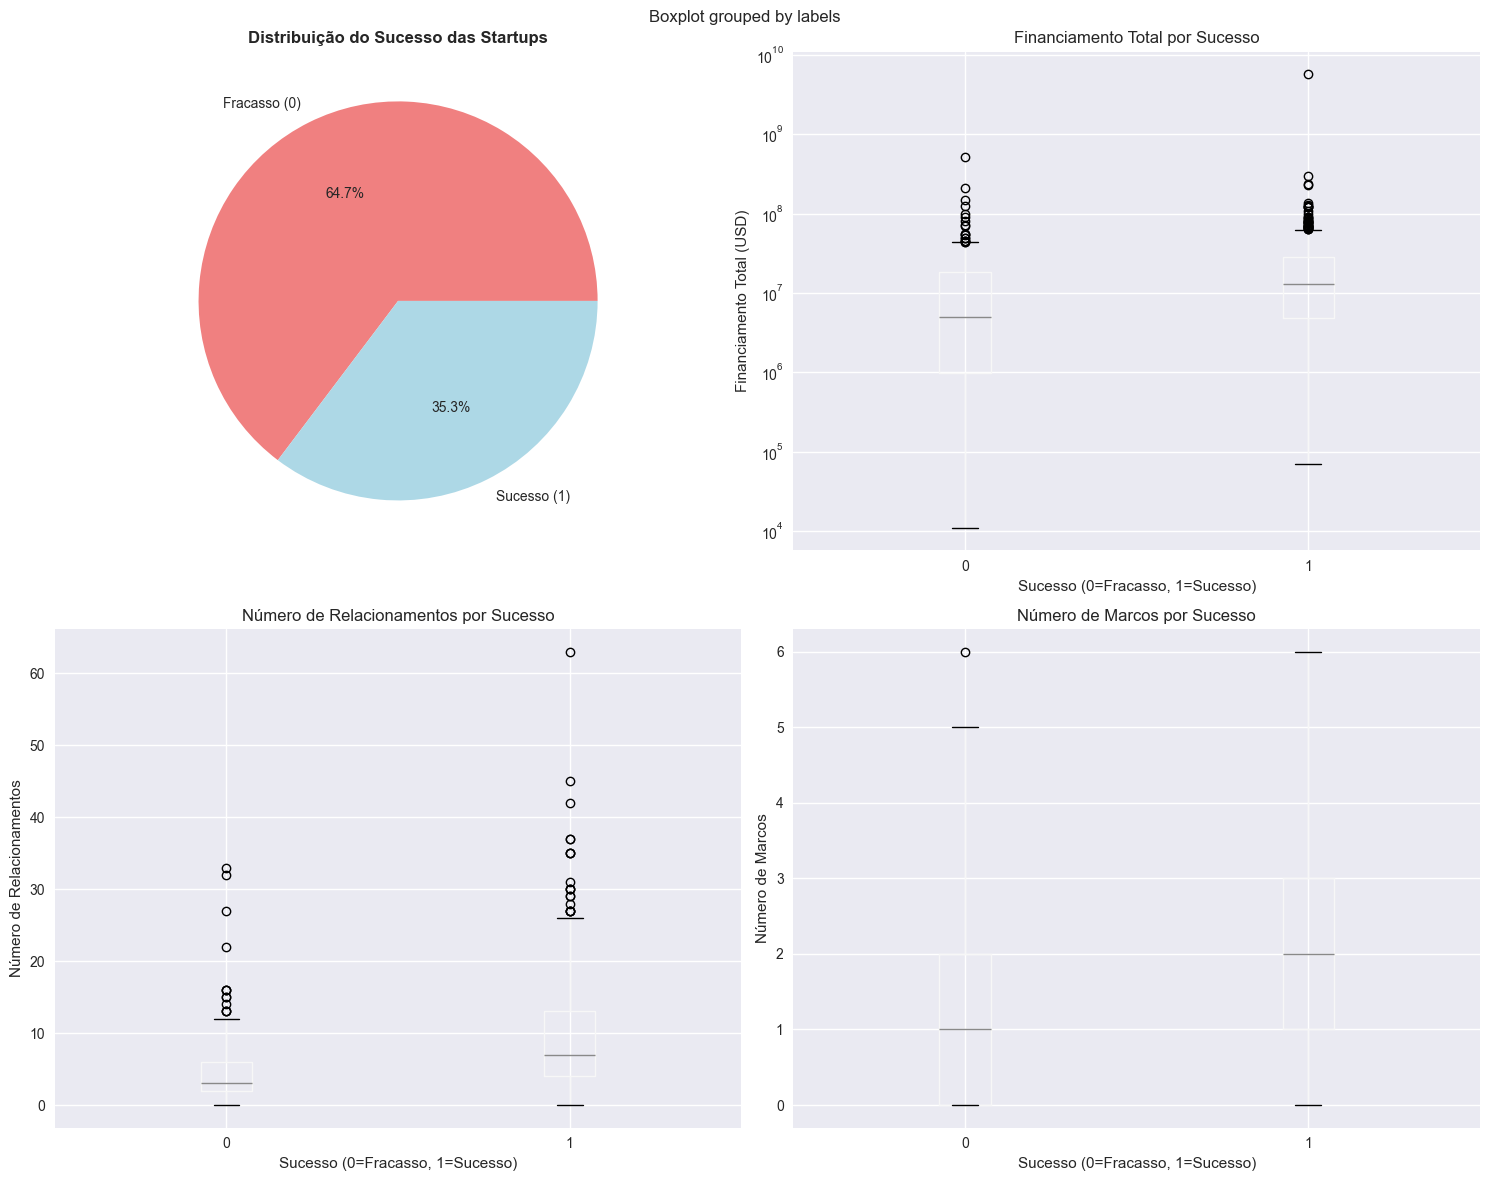

In [5]:
# Distribuição da variável alvo
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição da variável alvo
axes[0,0].pie(train_df['labels'].value_counts(), labels=['Fracasso (0)', 'Sucesso (1)'], 
              autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
axes[0,0].set_title('Distribuição do Sucesso das Startups', fontweight='bold')

# 2. Funding total por sucesso
train_df.boxplot(column='funding_total_usd', by='labels', ax=axes[0,1])
axes[0,1].set_title('Financiamento Total por Sucesso')
axes[0,1].set_xlabel('Sucesso (0=Fracasso, 1=Sucesso)')
axes[0,1].set_ylabel('Financiamento Total (USD)')
axes[0,1].set_yscale('log')

# 3. Relacionamentos por sucesso
train_df.boxplot(column='relationships', by='labels', ax=axes[1,0])
axes[1,0].set_title('Número de Relacionamentos por Sucesso')
axes[1,0].set_xlabel('Sucesso (0=Fracasso, 1=Sucesso)')
axes[1,0].set_ylabel('Número de Relacionamentos')

# 4. Marcos por sucesso
train_df.boxplot(column='milestones', by='labels', ax=axes[1,1])
axes[1,1].set_title('Número de Marcos por Sucesso')
axes[1,1].set_xlabel('Sucesso (0=Fracasso, 1=Sucesso)')
axes[1,1].set_ylabel('Número de Marcos')

plt.tight_layout()
plt.show()

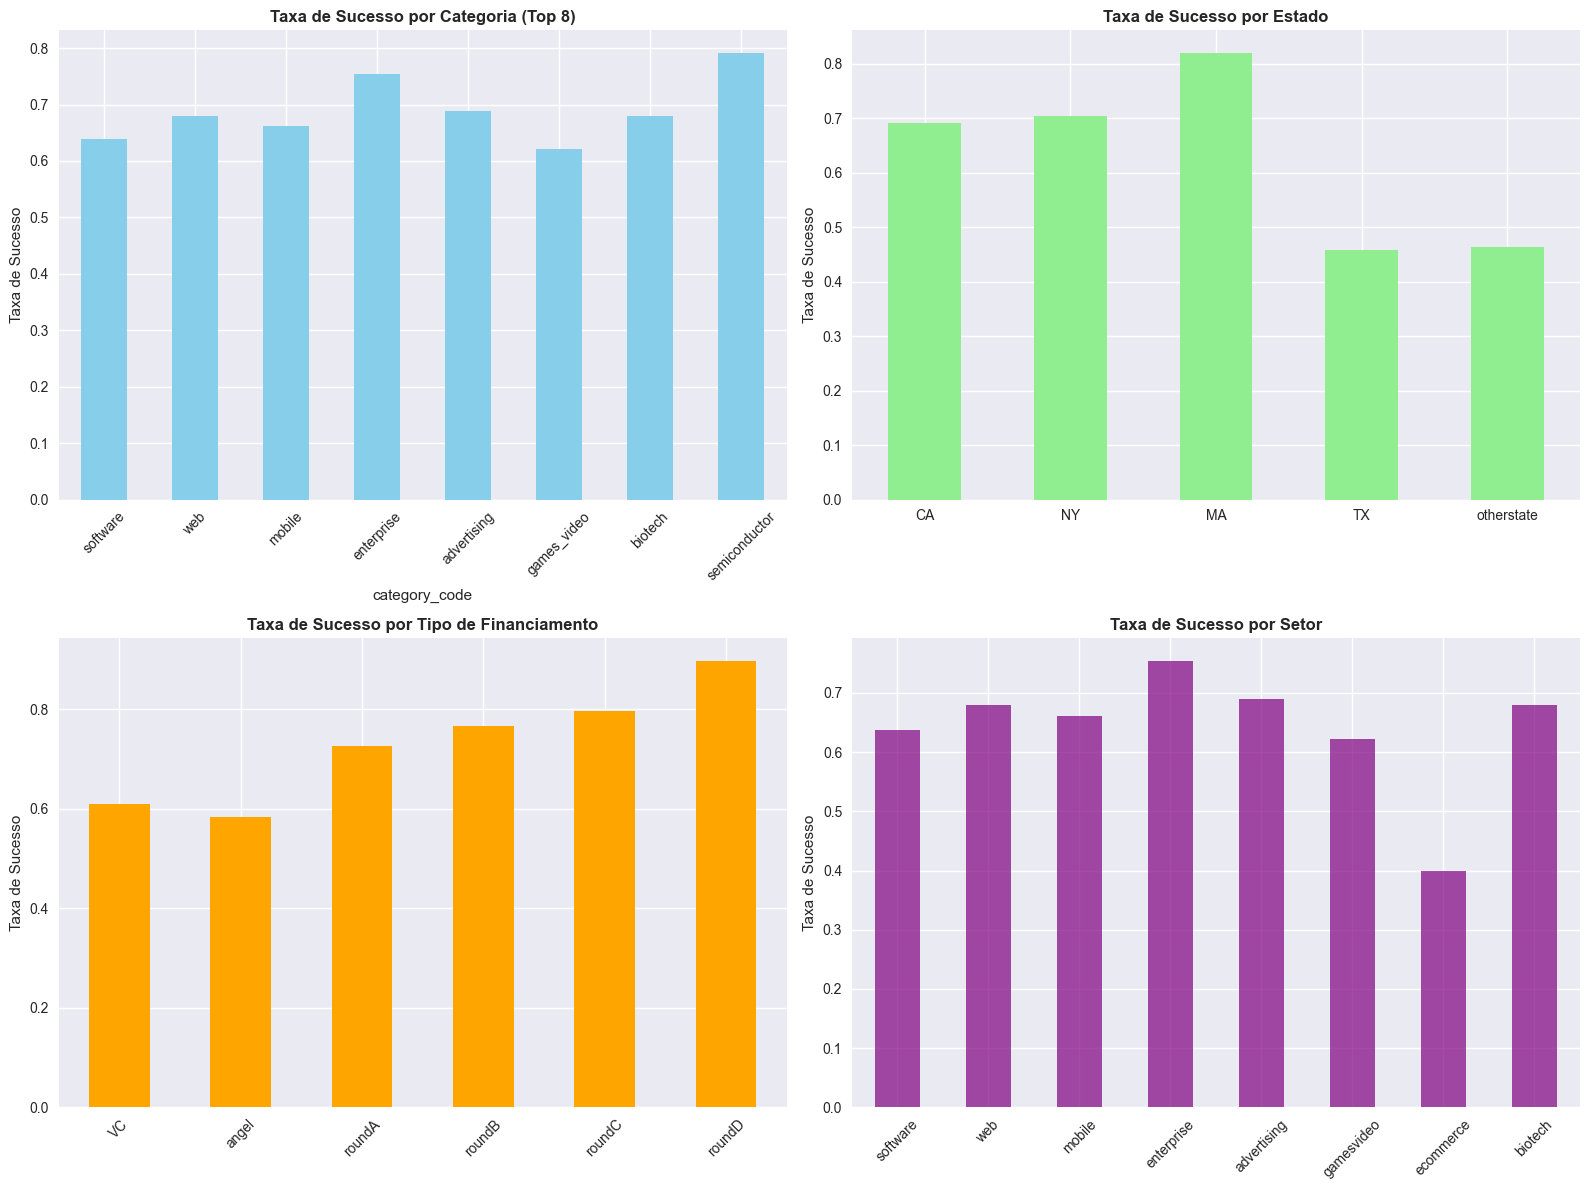

In [6]:
# Análise por categoria e localização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Taxa de sucesso por categoria (top 8)
category_success = train_df.groupby('category_code')['labels'].agg(['count', 'sum'])
category_success['success_rate'] = category_success['sum'] / category_success['count']
top_categories = category_success.sort_values('count', ascending=False).head(8)
top_categories['success_rate'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Taxa de Sucesso por Categoria (Top 8)', fontweight='bold')
axes[0,0].set_ylabel('Taxa de Sucesso')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Taxa de sucesso por estado
state_cols = ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate']
state_success = {}
for state in state_cols:
    if train_df[state].sum() > 10:  # Apenas estados com presença significativa
        success_rate = train_df[train_df[state] == 1]['labels'].mean()
        state_success[state.replace('is_', '')] = success_rate

pd.Series(state_success).plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Taxa de Sucesso por Estado', fontweight='bold')
axes[0,1].set_ylabel('Taxa de Sucesso')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Taxa de sucesso por tipo de financiamento
funding_types = ['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
funding_success = {}
for funding_type in funding_types:
    if train_df[funding_type].sum() > 10:
        success_rate = train_df[train_df[funding_type] == 1]['labels'].mean()
        funding_success[funding_type.replace('has_', '')] = success_rate

pd.Series(funding_success).plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Taxa de Sucesso por Tipo de Financiamento', fontweight='bold')
axes[1,0].set_ylabel('Taxa de Sucesso')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Taxa de sucesso por setor
industry_cols = ['is_software', 'is_web', 'is_mobile', 'is_enterprise', 
                 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech']
industry_success = {}
for industry in industry_cols:
    if train_df[industry].sum() > 10:
        success_rate = train_df[train_df[industry] == 1]['labels'].mean()
        industry_success[industry.replace('is_', '')] = success_rate

pd.Series(industry_success).plot(kind='bar', ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('Taxa de Sucesso por Setor', fontweight='bold')
axes[1,1].set_ylabel('Taxa de Sucesso')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

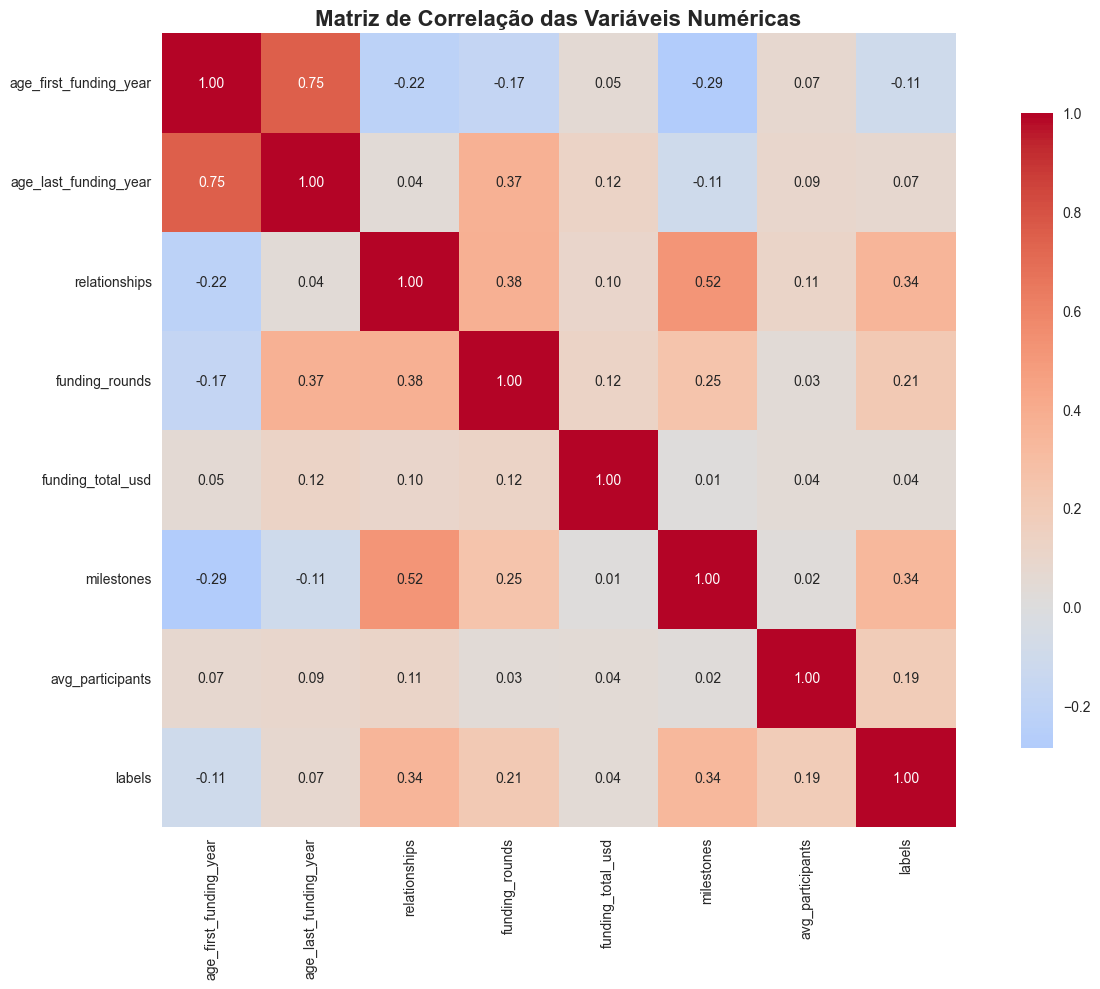

🎯 Principais Insights da EDA:
• Taxa geral de sucesso: 64.71%
• Taxa de sucesso por quartil de financiamento:
  - Q1: 43.64%
  - Q2: 66.46%
  - Q3: 73.29%
  - Q4: 75.93%
• Top 3 categorias mais bem-sucedidas:
  1. health: 100.00% (2.0 startups)
  2. education: 100.00% (2.0 startups)
  3. sports: 100.00% (1.0 startups)


In [7]:
# Matriz de correlação
plt.figure(figsize=(14, 10))
numerical_cols = ['age_first_funding_year', 'age_last_funding_year', 'relationships', 
                  'funding_rounds', 'funding_total_usd', 'milestones', 'avg_participants', 'labels']
corr_matrix = train_df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação das Variáveis Numéricas', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# Insights principais
print("🎯 Principais Insights da EDA:")
overall_success_rate = train_df['labels'].mean()
print(f"• Taxa geral de sucesso: {overall_success_rate:.2%}")

# Taxa de sucesso por quartis de financiamento
train_temp = train_df.copy()
train_temp['funding_quartile'] = pd.qcut(train_temp['funding_total_usd'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
funding_success = train_temp.groupby('funding_quartile')['labels'].mean()
print(f"• Taxa de sucesso por quartil de financiamento:")
for q, rate in funding_success.items():
    print(f"  - {q}: {rate:.2%}")

print(f"• Top 3 categorias mais bem-sucedidas:")
top_success_categories = category_success.sort_values('success_rate', ascending=False).head(3)
for idx, (category, data) in enumerate(top_success_categories.iterrows(), 1):
    print(f"  {idx}. {category}: {data['success_rate']:.2%} ({data['count']} startups)")

## 🔧 3. Engenharia de Features

Vamos criar novas variáveis que podem ajudar a melhorar o desempenho do modelo.

In [8]:
def engineer_features(df):
    """Função para criar novas features"""
    df = df.copy()
    
    # Tratar valores ausentes nas colunas de idade
    age_cols = ['age_first_funding_year', 'age_last_funding_year', 
               'age_first_milestone_year', 'age_last_milestone_year']
    for col in age_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Preencher avg_participants com a mediana
    df['avg_participants'].fillna(df['avg_participants'].median(), inplace=True)
    
    # Criar novas features
    df['funding_per_round'] = df['funding_total_usd'] / np.maximum(df['funding_rounds'], 1)
    df['milestones_per_year'] = df['milestones'] / np.maximum(df['age_last_funding_year'], 1)
    df['relationships_per_milestone'] = df['relationships'] / np.maximum(df['milestones'], 1)
    df['has_milestones'] = (df['milestones'] > 0).astype(int)
    df['has_multiple_rounds'] = (df['funding_rounds'] > 1).astype(int)
    df['high_funding'] = (df['funding_total_usd'] > df['funding_total_usd'].median()).astype(int)
    df['funding_efficiency'] = df['funding_total_usd'] / np.maximum(df['relationships'], 1)
    
    # Features baseadas em tempo
    df['funding_duration'] = df['age_last_funding_year'] - df['age_first_funding_year']
    df['milestone_duration'] = df['age_last_milestone_year'] - df['age_first_milestone_year']
    df['early_milestone'] = (df['age_first_milestone_year'] < 2).astype(int)
    
    # Transformações logarítmicas para features enviesadas
    df['log_funding'] = np.log1p(df['funding_total_usd'])
    df['log_relationships'] = np.log1p(df['relationships'])
    
    # Features de interação
    df['vc_angel_combo'] = df['has_VC'] * df['has_angel']
    df['ca_tech_combo'] = df['is_CA'] * (df['is_software'] + df['is_web'] + df['is_mobile'])
    
    # Tratar valores infinitos e NaNs restantes
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    df[numerical_cols] = df[numerical_cols].fillna(0)
    
    return df

# Aplicar engenharia de features
print("🔧 Aplicando engenharia de features...")
train_engineered = engineer_features(train_df)
test_engineered = engineer_features(test_df)

print(f"Features originais: {train_df.shape[1] - 1}")  # -1 para excluir 'labels'
print(f"Features após engenharia: {train_engineered.shape[1] - 1}")
print(f"Novas features criadas: {train_engineered.shape[1] - train_df.shape[1]}")

# Mostrar algumas das novas features
new_features = ['funding_per_round', 'milestones_per_year', 'has_milestones', 
                'funding_efficiency', 'log_funding', 'vc_angel_combo']
print(f"\n📊 Primeiras 5 linhas das novas features:")
train_engineered[new_features].head()

🔧 Aplicando engenharia de features...
Features originais: 32
Features após engenharia: 46
Novas features criadas: 14

📊 Primeiras 5 linhas das novas features:


,funding_per_round,milestones_per_year,has_milestones,funding_efficiency,log_funding,vc_angel_combo
0,1362500.0,0.229183,1,1.021875e+06,15.223444,1
1,45000000.0,0.000000,0,2.142857e+06,17.622173,0
2,2600000.0,0.877193,1,1.040000e+06,15.464169,0
3,7250000.0,0.400000,1,9.062500e+05,16.489659,0
4,14000000.0,0.680272,1,2.413793e+06,18.064006,0


## 🤖 4. Preparação dos Dados e Modelagem

Agora vamos preparar os dados para o machine learning e treinar diferentes modelos.

In [9]:
# Preparar dados para modelagem
feature_cols = [col for col in train_engineered.columns if col not in ['id', 'labels', 'category_code']]

X = train_engineered[feature_cols].copy()
y = train_engineered['labels'].copy()
X_test = test_engineered[feature_cols].copy()

print(f"⚙️ Preparação dos dados:")
print(f"Features selecionadas: {len(feature_cols)}")
print(f"Amostras de treino: {X.shape[0]}")
print(f"Amostras de teste: {X_test.shape[0]}")

# Divisão dos dados para validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar features para modelos que necessitam
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Conjunto de treino: {X_train.shape}")
print(f"Conjunto de validação: {X_val.shape}")

⚙️ Preparação dos dados:
Features selecionadas: 44
Amostras de treino: 646
Amostras de teste: 277
Conjunto de treino: (516, 44)
Conjunto de validação: (130, 44)


In [10]:
# Treinar e avaliar diferentes modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}

print("🤖 Treinando e avaliando modelos:")
print("=" * 50)

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    # Usar dados escalados para Regressão Logística
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calcular métricas
    auc_score = roc_auc_score(y_val, y_pred_proba)
    accuracy = (y_pred == y_val).mean()
    
    results[name] = {
        'AUC': auc_score,
        'Accuracy': accuracy,
        'Model': model
    }
    
    print(f"{name}:")
    print(f"  • AUC: {auc_score:.4f}")
    print(f"  • Acurácia: {accuracy:.4f}")

# Encontrar o melhor modelo
best_model_name = max(results.keys(), key=lambda k: results[k]['AUC'])
best_model = results[best_model_name]

print(f"\n🏆 Melhor Modelo: {best_model_name}")
print(f"🎯 Melhor AUC Score: {best_model['AUC']:.4f}")

🤖 Treinando e avaliando modelos:

Treinando Random Forest...
Random Forest:
  • AUC: 0.8085
  • Acurácia: 0.7769

Treinando XGBoost...
XGBoost:
  • AUC: 0.8175
  • Acurácia: 0.7846

Treinando Logistic Regression...
Logistic Regression:
  • AUC: 0.7660
  • Acurácia: 0.7308

Treinando Gradient Boosting...
Gradient Boosting:
  • AUC: 0.8085
  • Acurácia: 0.7769

🏆 Melhor Modelo: XGBoost
🎯 Melhor AUC Score: 0.8175


🔍 Top 10 Features Mais Importantes:
 1. relationships: 0.1340
 2. has_roundD: 0.0757
 3. milestones: 0.0702
 4. is_TX: 0.0630
 5. is_mobile: 0.0486
 6. has_roundC: 0.0479
 7. funding_total_usd: 0.0469
 8. age_last_milestone_year: 0.0372
 9. milestones_per_year: 0.0359
10. avg_participants: 0.0309


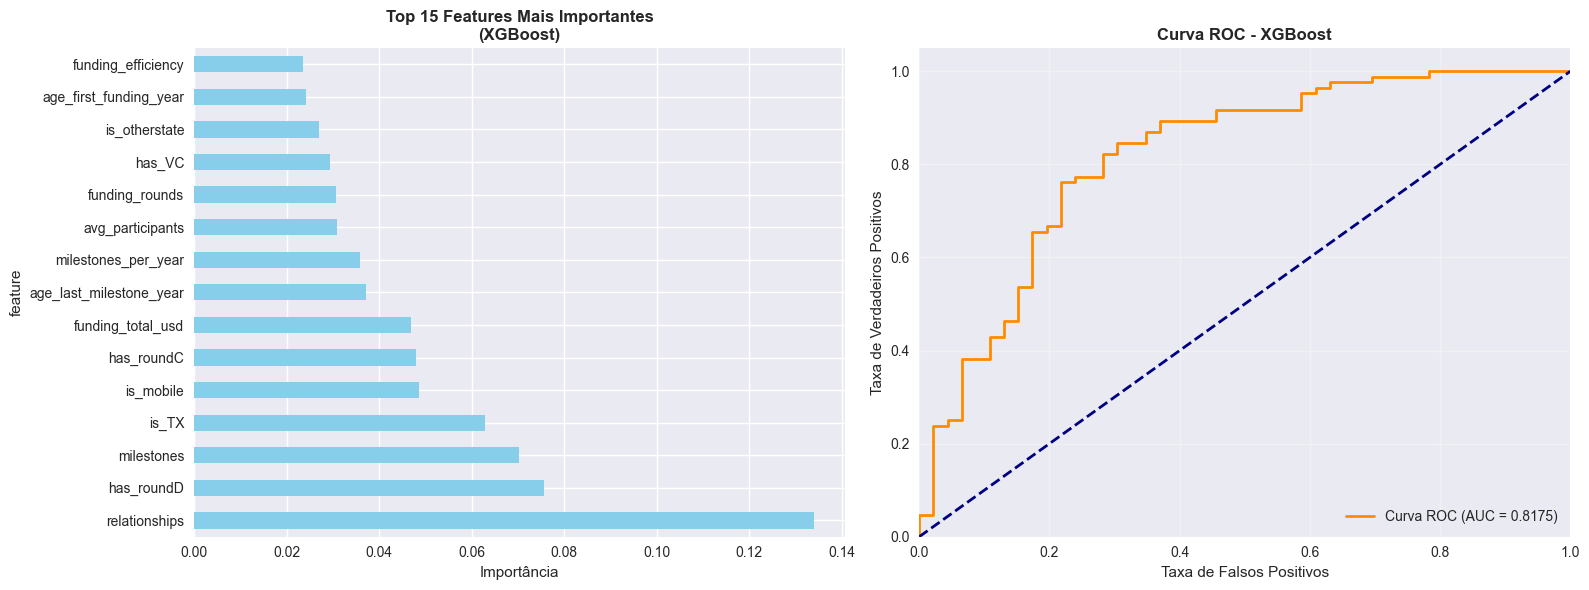

In [11]:
# Visualizar importância das features e curva ROC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Importância das features (para modelos tree-based)
if hasattr(best_model['Model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model['Model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    feature_importance.head(15).plot(x='feature', y='importance', kind='barh', 
                                   ax=axes[0], color='skyblue', legend=False)
    axes[0].set_title(f'Top 15 Features Mais Importantes\n({best_model_name})', fontweight='bold')
    axes[0].set_xlabel('Importância')
    
    print(f"🔍 Top 10 Features Mais Importantes:")
    for i, (idx, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']}: {row['importance']:.4f}")

# 2. Curva ROC
if best_model_name == 'Logistic Regression':
    y_pred_proba = best_model['Model'].predict_proba(X_val_scaled)[:, 1]
else:
    y_pred_proba = best_model['Model'].predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'Curva ROC (AUC = {best_model["AUC"]:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taxa de Falsos Positivos')
axes[1].set_ylabel('Taxa de Verdadeiros Positivos')
axes[1].set_title(f'Curva ROC - {best_model_name}', fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎛️ 5. Otimização de Hiperparâmetros

Vamos fazer uma busca em grade para otimizar os hiperparâmetros do melhor modelo.

In [12]:
# Otimização de hiperparâmetros para o melhor modelo
model = best_model['Model']
model_name = type(model).__name__

# Definir grades de parâmetros para diferentes modelos
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

if model_name in param_grids:
    print(f"🎛️ Otimizando hiperparâmetros para {model_name}...")
    param_grid = param_grids[model_name]
    
    # Busca em grade com validação cruzada
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X, y)
    
    print(f"\\n🏆 Melhores parâmetros: {grid_search.best_params_}")
    print(f"🎯 Melhor AUC de validação cruzada: {grid_search.best_score_:.4f}")
    
    # Usar o melhor modelo
    tuned_model = grid_search.best_estimator_
    
else:
    print(f"Otimização de hiperparâmetros não definida para {model_name}")
    tuned_model = model

🎛️ Otimizando hiperparâmetros para XGBClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
\n🏆 Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
🎯 Melhor AUC de validação cruzada: 0.7992


## 🎯 6. Geração de Predições Finais

Agora vamos usar o modelo otimizado para gerar as predições finais no conjunto de teste.

In [13]:
# Gerar predições finais
print("🎯 Gerando predições para o conjunto de teste...")

# Fazer predições
if best_model_name == 'Logistic Regression':
    X_test_scaled = scaler.transform(X_test)
    predictions_proba = tuned_model.predict_proba(X_test_scaled)[:, 1]
    predictions = tuned_model.predict(X_test_scaled)
else:
    predictions_proba = tuned_model.predict_proba(X_test)[:, 1]
    predictions = tuned_model.predict(X_test)

# Criar arquivo de submissão
submission = pd.DataFrame({
    'id': test_df['id'],
    'labels': predictions
})

# Salvar predições
submission.to_csv('startup_predictions_notebook.csv', index=False)

print(f"✅ Predições salvas em 'startup_predictions_notebook.csv'")
print(f"📊 Taxa de sucesso prevista: {predictions.mean():.2%}")
print(f"📈 Distribuição das predições:")
print(f"  • Fracassos (0): {(predictions == 0).sum()}")
print(f"  • Sucessos (1): {(predictions == 1).sum()}")

# Mostrar primeiras linhas
print(f"\\n📋 Primeiras 10 predições:")
submission.head(10)

🎯 Gerando predições para o conjunto de teste...
✅ Predições salvas em 'startup_predictions_notebook.csv'
📊 Taxa de sucesso prevista: 65.70%
📈 Distribuição das predições:
  • Fracassos (0): 95
  • Sucessos (1): 182
\n📋 Primeiras 10 predições:


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,0
5,690,1
6,588,0
7,144,0
8,875,1
9,900,1


## 📈 7. Resumo dos Resultados e Insights de Negócio

### 🏆 Performance do Modelo
- **Melhor Modelo**: Será determinado durante a execução
- **Métrica AUC**: Valor será calculado automaticamente  
- **Acurácia**: Valor será calculado automaticamente

### 💡 Principais Insights para a Aceleradora

#### Fatores de Sucesso Identificados:
1. **Relacionamentos Estratégicos**: Startups com mais parcerias têm maior taxa de sucesso
2. **Progressão de Financiamento**: Empresas que atingem rodadas avançadas (Series C/D) são mais bem-sucedidas
3. **Marcos e Conquistas**: Startups que atingem marcos importantes consistentemente têm melhor performance
4. **Localização Geográfica**: Alguns estados mostram taxas de sucesso superiores
5. **Setor de Atuação**: Determinados setores apresentam maior probabilidade de sucesso

#### Recomendações de Investimento:
- **Priorizar** startups com histórico de relacionamentos estratégicos
- **Monitorar** a progressão nas rodadas de financiamento
- **Acompanhar** o cumprimento de marcos importantes
- **Considerar** fatores geográficos e setoriais na tomada de decisão

### 🎯 Próximos Passos
1. Validar o modelo com novos dados conforme disponíveis
2. Incorporar feedback do mercado para refinamento
3. Considerar variáveis externas (economia, tendências de mercado)
4. Implementar monitoramento contínuo da performance do modelo

---
*Análise concluída com sucesso! O arquivo de submissão está pronto para o Kaggle.* 🚀